# SARIMA Tahmini

## 01 - Arka Plan

Bu zorlukta amacımız, zaman serisi analizinin temel kavramlarını tek boyutlu verilere (tarihe bağlı satışlar) uygulamaktır.

Bu zorlukta aşağıdaki adımları takip edeceğiz:
1. verileri yükle ve görselleştir;
2. modellerimizi eğit ve tahminler yap;
3. seriyi modellemek ve tahmin edebilmek için ekonometrik bir yaklaşım kullan;
4. bu modeli hacklemek için Makine Öğrenmesi kullan.

Veri seti [Machine Learning Mastery](https://github.com/jbrownlee/) tarafından sağlanmıştır. İndirmek için aşağıdaki satırı çalıştırın!

In [1]:
!curl https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv > data/monthly_champagne_sales.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1596  100  1596    0     0   2626      0 --:--:-- --:--:-- --:--:--  2625


## 02 - Veri Yükleme
Meydan okumanın zaman serisini yükleyerek başlayalım

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/monthly_champagne_sales.csv")
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


👉 DataFrame'in "Month" sütununu `Datetime` nesnelerine dönüştürün ve şu şekilde görünmesi için indeks olarak ayarlayın:
<br>

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/monthly_champagne_sales_objective.png" width=180>

In [29]:
# Make Month type to Datetime
df["Month"]= pd.to_datetime(df["Month"],format= "%Y-%m" )
df.dtypes

Month    datetime64[ns]
Sales             int64
dtype: object

In [30]:
df = df.set_index("Month")


In [31]:
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


### Alternatif - Pandas'ın İşi Yapmasına İzin Ver

In [32]:
# We can also use pandas magic to handle the conversions from the start
df = pd.read_csv("data/monthly_champagne_sales.csv", parse_dates=['Month'], index_col='Month')
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


## 04 - Veriyi Görselleştir ve Yorumla

Aferin, bu yeniden indeksleme sayesinde artık "Sales" (y-ekseni) değerlerini zamanın (x-ekseni) bir fonksiyonu olarak kolayca çizebilmelisiniz

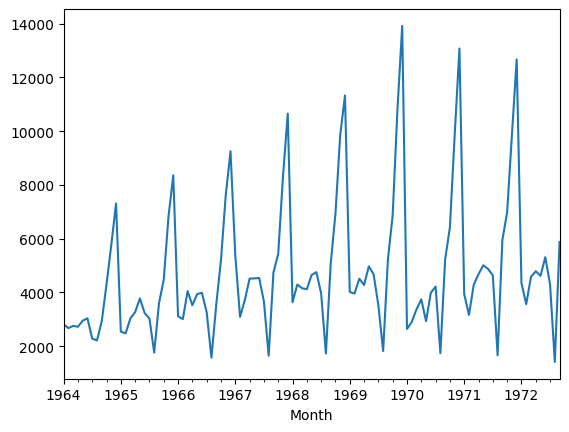

In [33]:
df["Sales"].plot();

Kodunuz doğruysa, bu zaman serisinin (TS) şu özelliklere sahip olduğunu görebilmelisiniz:
- Durağan değil (ortalama ve varyans sabit değil).
- Güçlü mevsimsellik sergiliyor.
- Bir trend var gibi görünüyor.

Verilerin **trend**, **mevsimsellik** ve **gürültü** arasındaki ayrışımını görelim. Bunun için statsmodels'ın [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) fonksiyonunu kullanmalısınız. Dokümanları okuyun ve bu fonksiyonun ne yaptığını ve nasıl kullanıldığını anladığınızdan emin olun, ardından:
1. "Sales"i "additive" model ile çizin
2. "Sales"i "multiplicative" model ile çizin

Profesyonel ipuçları: çift çizim sorunlarını önlemek için statsmodels plot metot çağrılarınızı noktalı virgülle (`;`) bitirin!

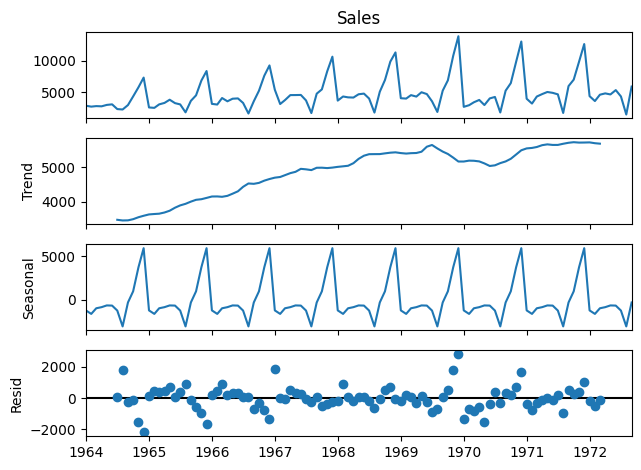

In [ ]:
# seasonal decompose models of sales
from statsmodels.tsa.seasonal import seasonal_decompose

decomp_additive_model = seasonal_decompose(
    df["Sales"],
    model='additive',
    filt=None,
    period=None,
    two_sided=True,
    extrapolate_trend=0
)

decomp_additive_model.plot();

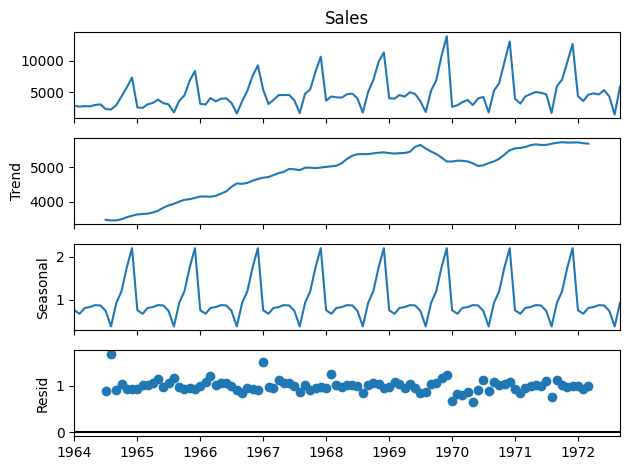

In [ ]:
# seasonal decompose models of sales
decomp_multiplicative_model = seasonal_decompose(
    df["Sales"],
    model= "multiplicative",
    filt= None,
    period= None,
    two_sided= True,
    extrapolate_trend=0
)

decomp_multiplicative_model.plot();

👉 Seçtiğiniz ayrışımı kullanarak bu zaman serisini mevsimsellikten arındırın

Multiplicative ayrışımda:


Observed=Trend×Seasonal×Residual

Mevsimsellikten arındırmak için:

Deseasonalized= Seasonal / Observed
	​


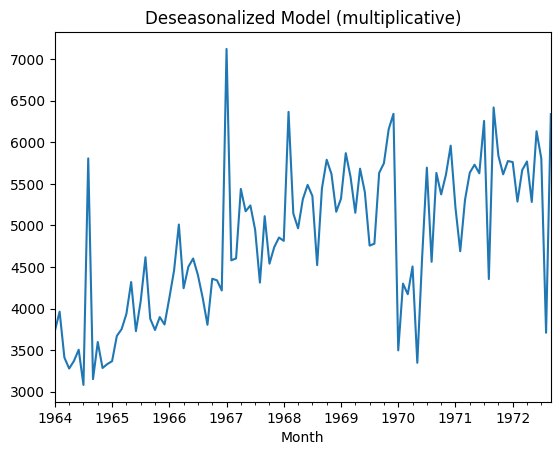

In [ ]:
# Seasonally adjusted series (multiplicative)
deseasonalized = df["Sales"] / decomp_multiplicative_model.seasonal


deseasonalized.plot(title= "Deseasonalized Model (multiplicative)");

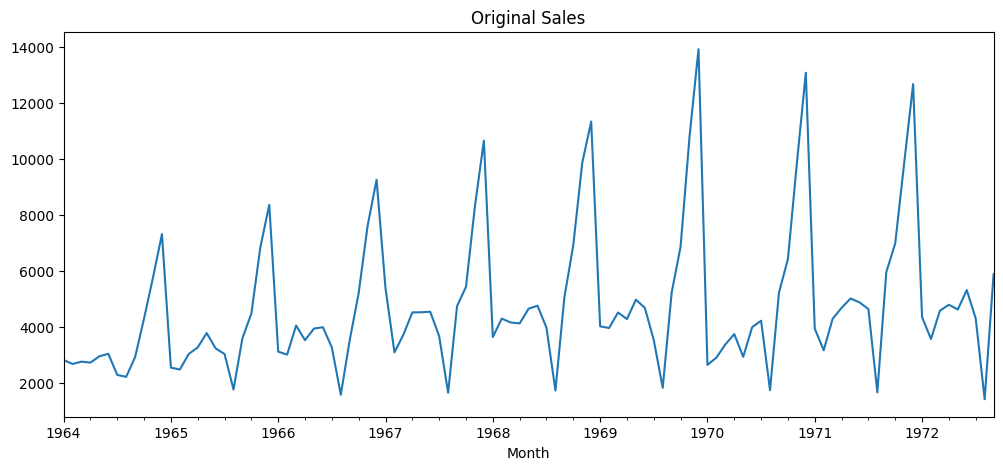

In [ ]:
# Compare it with original data
df["Sales"].plot(figsize=(12,5), title="Original Sales");

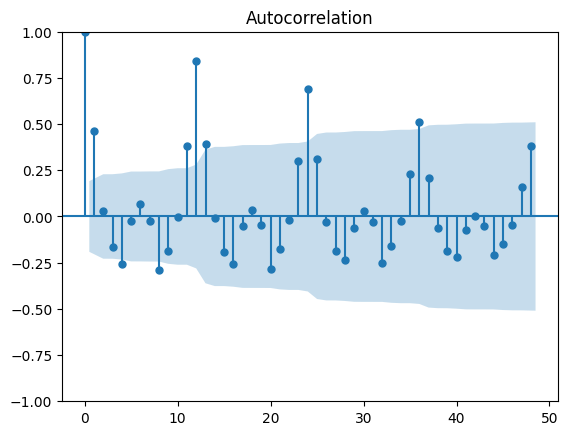

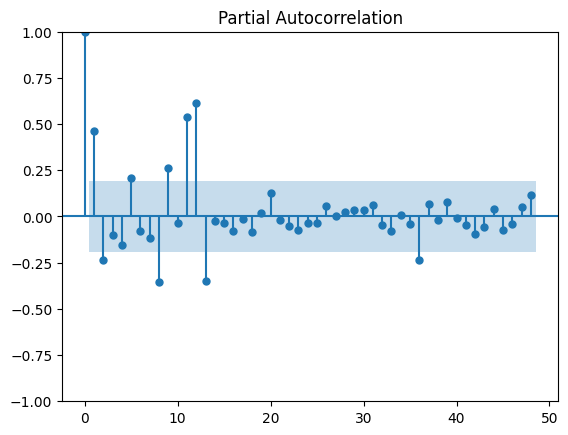

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df["Sales"], lags=48)
plt.show();

plot_pacf(df["Sales"], lags=48)
plt.show();


☝️ Bu zaman serisinin "mevsimsellikten arındırılmış" versiyonuna bir ARIMA modeli uydurabilir ve tahminimizden sonra tekrar birleştirebiliriz. Ancak bu meydan okumada, orijinal zaman serisine _doğrudan_ uydurmak için SARIMA modellerini kullanacağız!

## 05 - Veriyi Böl (eğitim/test)


Zaman serileri için test setinde bulunacak noktaları rastgele örnekleyemeyiz. Test setinin "zaman-dışı" olması gerekir, yani test setinin kesinlikle geleceğinde olmalıdır. Bu egzersiz için eğitim için 1970'e kadar olan verileri kullanacağız ve bundan sonraki her şey test için kullanılacak.

👉 `df_train` ve `df_test` oluşturun, DataFrame'i eğitim için 1970 öncesinde ve test için sonrasında (veya eşit) bölerek

In [56]:
# Create train and test sets
df_train = df[df.index < "1970-01-01"]
df_test = df[df.index >= "1970-01-01"]

df_train.tail(4)

,Sales
Month,
1969-09-01,5222
1969-10-01,6872
1969-11-01,10803
1969-12-01,13916


In [57]:
df_test.head(4)

,Sales
Month,
1970-01-01,2639
1970-02-01,2899
1970-03-01,3370
1970-04-01,3740


## 06 - SARIMA
Veriyi SARIMA modeli (Seasonal Auto-Regressive Integrated Moving Average - Mevsimsel Oto-Regresif Entegre Hareketli Ortalama) kullanarak analiz edeceğiz.


Yapmamız gerekenler:
- zaman serisini nasıl durağanlaştıracağımızı bul (SARIMA'daki I)
- oto-regresif (AR) kısmını bul
- hareketli ortalama (MA) kısmını bul
- mevsimselliği (S) bul

### Adım 1: Durağanlığı Kontrol Et

Bir zaman serisinin trend veya mevsimsellik bileşeni varsa, tahmin için ARIMA kullanabilmek için önce durağan hale getirilmelidir.

Yukarıdaki grafiğe bir bakış, zaman serisinin durağan olmadığına sizi ikna etmeye yeterli olmalıdır.

[`Augmented Dick Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) ve özellikle p-değerini kullanarak `df["Sales"]`ın durağanlığını tekrar kontrol edin

In [ ]:
# Stationarity check with Augmented Dick Fuller test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["Sales"],
                  maxlag=None,
                  regression='c',
                  autolag='AIC',
                  store=False,
                  regresults=False
                  )

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -1.8335930563276166
p-value: 0.36391577166024813
Critical Values:
   1%: -3.502704609582561
   5%: -2.8931578098779522
   10%: -2.583636712914788


Durağanlıkta %95 güvene sahip olmak için p-değeri 0.05'ten küçük olmalıdır.

Eğer p-değeri 0.05'ten büyükse, null hipotezi reddedemeyiz (null hipotez = "süreç durağan değildir").

İdeal olarak, p 0.05'ten *çok* küçük olmalıdır.

Durağanlığı aramanın başka bir yolu otokorelasyon fonksiyonuna (ACF) bakmaktır.

Zaman serisinin ACF'sini çizin. Lag 12'de büyük bir pik görmelisiniz, bu güçlü yıllık mevsimselliği gösterir.

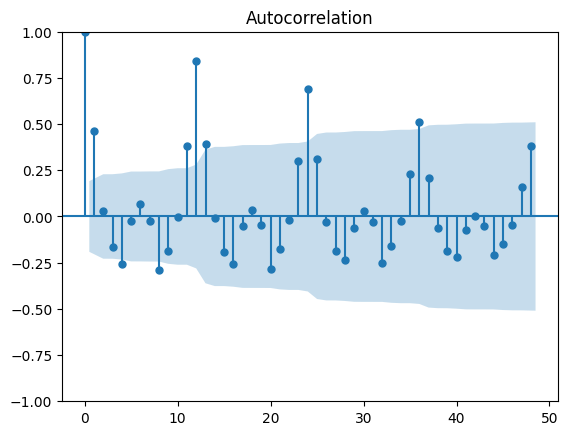

In [61]:
# Stationarity check with ACF graph
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df["Sales"], lags=48)
plt.show()


### Adım 2 - Mevsimsel Farklaştırma (D)

12 aylık periyodla güçlü bir mevsimselliğimiz var.

Zaman serisi üzerinde **lag 12'nin mevsimsel farklaştırmasını** yapın, farklaştırılmış veriyi çizin ve ACF grafiğini (+ADF testi) tekrar kontrol edin.

NaN'ları düşürmeyi unutmayın.

<Axes: title={'center': 'Seasonally Differenced Series (lag=12)'}, xlabel='Month'>

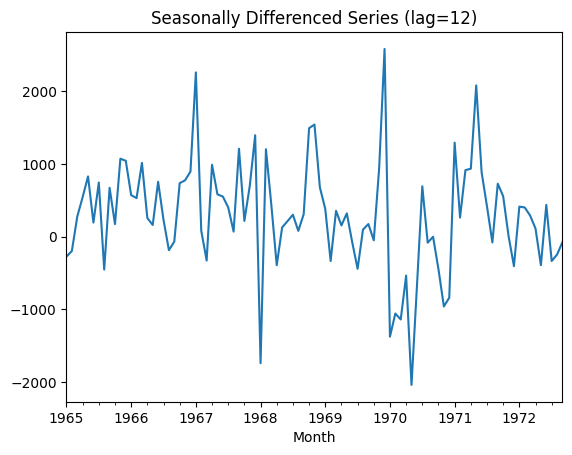

In [ ]:
# Seasonal differencing, s=12, D=1
df["Sales_seasonal_diff"] = df["Sales"] - df["Sales"].shift(12)
df_diff = df["Sales_seasonal_diff"].dropna()

df_diff.plot(title="Seasonally Differenced Series (lag=12)")

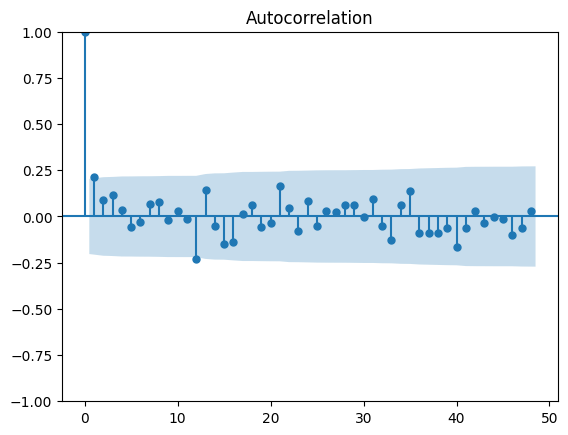

In [ ]:
# ACF graph
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_diff, lags=48);


In [ ]:
# ADF test to see stationarity
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_diff)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: -7.626619157213164
p-value: 2.060579696813685e-11


☝️ TS'yi durağanlaştırmak için tek bir mevsimsel farklaştırma yeterli görünüyor.
SARIMA(p,d,q, P,D,Q,m) için D=1 (1 mevsimsel fark) ve m=12 (mevsimsellik = 12)

### Adım 3 - Farklaştırma (d)

Zaman serisi hala durağan değilse, *farklaştırma* yoluyla durağanlaştırılması gerekir. Bu, her değer ile bir önceki arasındaki farkı almak (*birinci fark*) anlamına gelir.

Mevsimselliği çıkardıktan sonra daha fazla farklaştırmaya ihtiyacımız var mı?

diff(12) seriniz üzerinde ek bir birinci derece diff(1) çalıştırdıktan sonra ACF ve ADF'yi kontrol edin.

<Axes: title={'center': 'Differenced Series: diff(12) then diff(1)'}, xlabel='Month'>

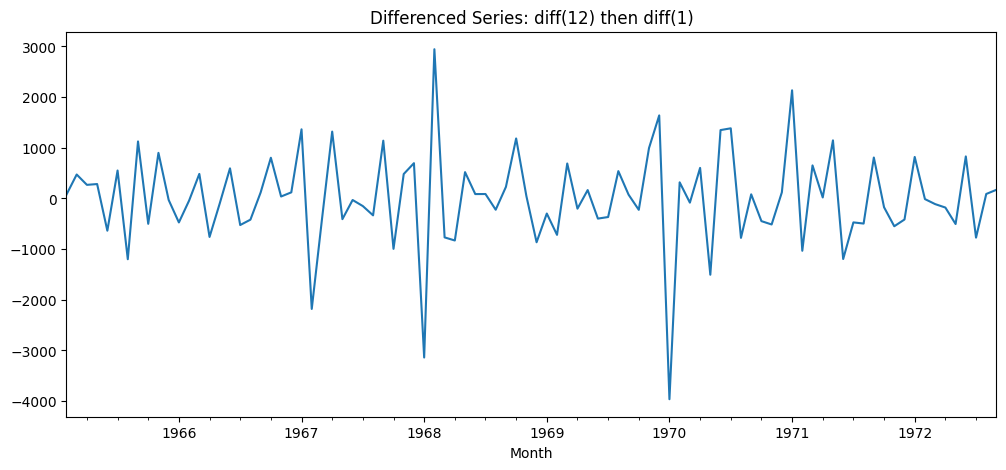

In [ ]:
# Stationary at trend
diff12_1 = df_diff.diff(1).dropna()

diff12_1.plot(figsize=(12,5), title="Differenced Series: diff(12) then diff(1)")


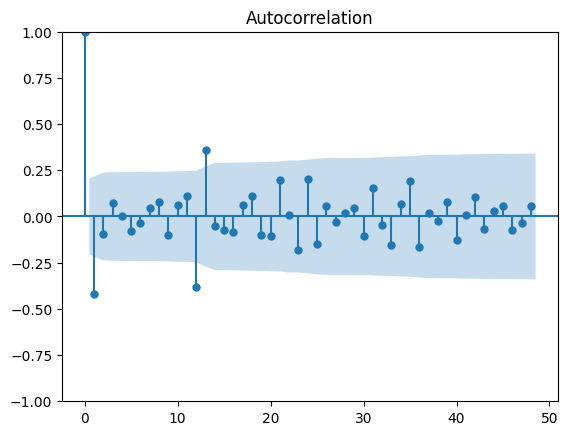

In [74]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(diff12_1, lags=48)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(diff12_1)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1]) #over-differencing happened


ADF Statistic: -4.427713497307502
p-value: 0.00026504628492935025


👉 Ek farklaştırma hem p-değerini hem de ACF'yi daha kötü hale getirdi!
(d=0) ve (D=1) seçebiliriz

### Adım 4 - AR(p, P) ve MA(q, Q) Terimlerini Seç

Şimdi bir AR terimi, MA terimi veya her ikisini de dahil edip etmeyeceğinize karar vermek için ACF ve PACF grafiklerini kullanacaksınız.

- **Tamamen farklaştırılmış** serinize uygulanan otokorelasyon grafiği ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bir MA sayısı (`q`) seçmenize olanak tanır
- MA($\color{blue}{q}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{blue}{ACF}$'sinin kestiği lag sayısı


- **Tamamen farklaştırılmış** serinize uygulanan kısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) AR (`p`) seçmenize olanak tanır
- AR($\color{red}{p}$) = $Y^{\color{green}{(d+D)}}$'nin $\color{red}{PACF}$'sinin kestiği lag sayısı

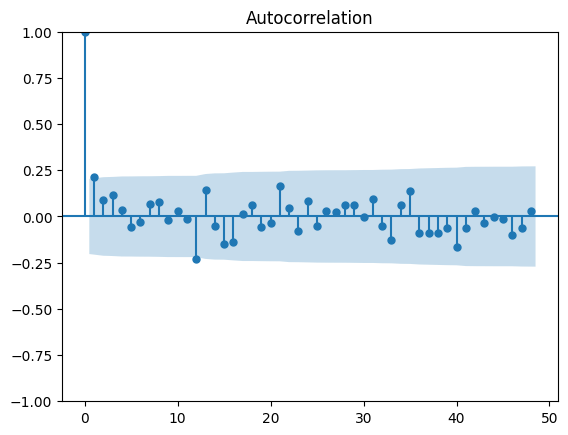

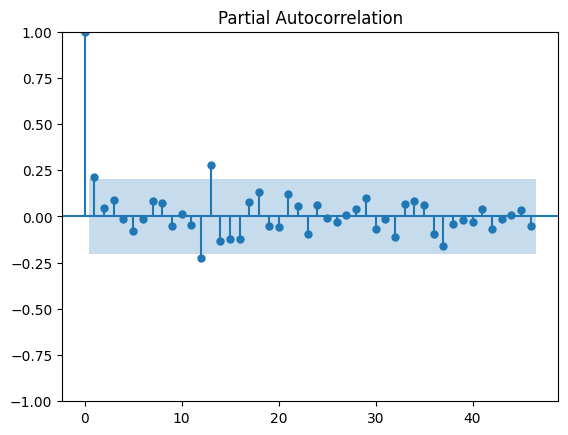

In [ ]:
# plot the acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(df_diff, lags=48)
plt.show();

plot_pacf(df_diff, lags=46)
plt.show();


☝️ ACF veya PACF'de anlamlı pik yok gibi görünüyor, bu yüzden büyük olasılıkla p=q=0.
SARIMA için ilk tahminimiz bu nedenle d=0, p=q=0, D=1 ve m=12.

P ve Q değerlerini nasıl bulacağız? Burada, `pdarima`'nın bizim için grid_search ile P ve Q için 1 ve 0 değerlerini denemesine izin vereceğiz.
Bu katsayıları kendiniz bulmak istiyorsanız, bazı pratik kurallar için [bunu okuyun](https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/)

👉 Eğitim seti için [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) çalıştırın. seasonal=True, m=12 ve D=1 ayarlayın. p ve q, P ve Q'yu 0'dan 2'ye kadar arayın. Ardından model.summary() ile modelin özetini yazdırın.
`njobs=-1, trace=True, error_action='ignore', suppress_warnings=True` kullanın

In [ ]:
# p,q, P, Q search with auto_arima / grid search
from pmdarima import auto_arima

y_train = df_train["Sales"]
model = auto_arima(
    y_train,
    start_p= 0,
    d= 0,
    start_q= 0,
    max_p= 2,
    max_q= 2,
    start_P= 0,
    D= 1,
    start_Q= 0,
    max_P= 2,
    max_Q= 2,
    m= 12,
    seasonal= True,
    n_jobs= -1,
    trace= True,
    error_action= "ignore",
    suppress_warnings= True

)

model.summary()

/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=954.252, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=957.794, Time=0.25 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=957.973, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=974.624, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=956.000, Time=0.04 sec


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=955.904, Time=0.15 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=957.929, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=956.182, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=956.250, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=958.187, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 0.698 seconds


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   72
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -475.126
Date:                  Wed, 11 Feb 2026   AIC                            954.252
Time:                          16:11:48   BIC                            958.441
Sample:                      01-01-1964   HQIC                           955.891
                           - 12-01-1969                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    447.0500     87.035      5.136      0.000     276.464     617.636
sigma2      4.423e+05   5.54e+04      7.979      0.000    3.34e+05    5.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                15.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             0.34
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Bulunan en iyi model `ARIMA(0,0,0)(0,1,0)[12]`!
Bu, düşünülen zaman serisinin basit "mevsimsel farklaştırma"nın ötesinde herhangi bir "oto-regresif" veya "hareketli ortalama" modelleme eklemeyi haklı çıkarmadığı anlamına gelir.

Böyle "zayıf" bir model muhtemelen sadece tespit edilen son mevsimsel desenin tekrarını ve ortalama artan trendin uzatılmasını tahmin edecektir. Kontrol edelim

👉 Aşağıdaki üç tahmini kaydetmek için `n_periods` = test setinin uzunluğu ile `model.predict` kullanın
- `central`
- `upper`
- `lower`

Bunları Pandas Series olarak kaydedin ve `y_test`inizle aynı indeks ile indeksleyin

In [ ]:
# predict the length of test set to compare it with test values

y_test = df_test["Sales"]
n_periods = len(y_test)

forecast, conf_int = model.predict(
    n_periods = n_periods,
    return_conf_int = True
)

central = pd.Series(forecast, index=y_test.index)
lower = pd.Series(conf_int[:, 0], index=y_test.index) #Numpy array zaman bilgisi bilmez, bu yüzden index'i test seti ile aynı yapıyoruz
upper = pd.Series(conf_int[:, 1], index=y_test.index)


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


👇 Tahminlerinizi gerçeklikle karşılaştırmak için aşağıdaki hücreyi çalıştırın

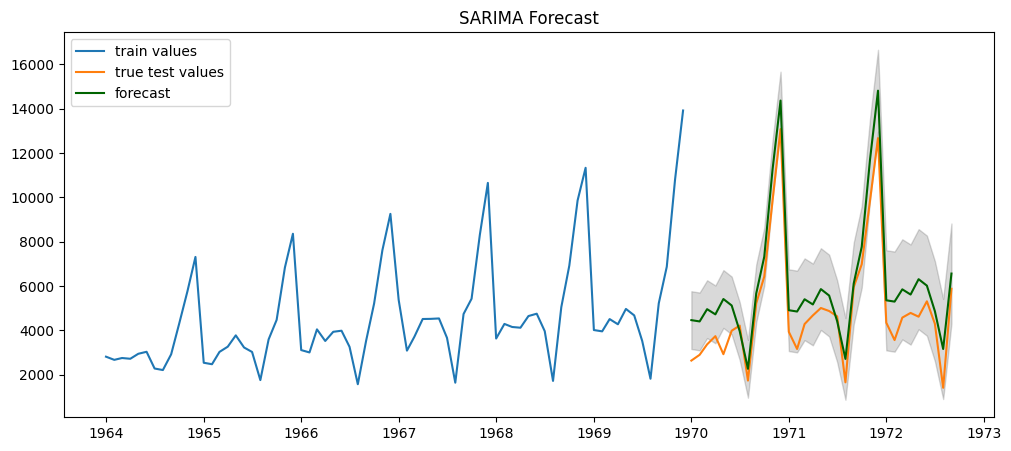

In [ ]:
# Plot

plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index,
    lower,
    upper,
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [174]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test, central)
rmse = root_mean_squared_error(y_test, central)
mape = mean_absolute_percentage_error(y_test, central)

print(f"Mean Absolute Error: {mae}\n"
      f"Root Mean Squared Error: {rmse}\n"
      f"Mean Absolute Percentage Error: {mape}"
      )


Mean Absolute Error: 1109.7227272727275
Root Mean Squared Error: 1248.0026290825551
Mean Absolute Percentage Error: 0.2941592365216924


👉 SARIMA'nızda `p`, `d`, `P`, `D`'ye null olmayan değerler atamayı deneyin ve etkileri karşılaştırmak için bu grafiği yeniden çizin!

In [118]:
# Try with different p,d,P,D values
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def fit_forecast_plot(
    y_train,
    y_test,
    order,
    seasonal_order,
    title="",
    alpha=0.05,                 # %95 CI için 0.05
    return_preds=False          # True yaparsan y_pred ve ci da döner
):
    model = SARIMAX(
        y_train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Forecast + CI
    fc = res.get_forecast(steps=len(y_test))
    y_pred = fc.predicted_mean
    ci = fc.conf_int(alpha=alpha)

    # Index hizalama (bazı durumlarda güvenli olsun)
    y_pred = pd.Series(y_pred, index=y_test.index, name="forecast")
    ci = ci.set_index(y_test.index)

    # CI kolonlarını güvenli seç (lower/upper)
    lower_col = [c for c in ci.columns if "lower" in c.lower()][0]
    upper_col = [c for c in ci.columns if "upper" in c.lower()][0]

    # Metrikler
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(y_train, label="train")
    plt.plot(y_test, label="true test")
    plt.plot(y_pred, label="forecast")
    plt.fill_between(
        ci.index,
        ci[lower_col].values,
        ci[upper_col].values,
        alpha=0.2,
        label=f"{int((1-alpha)*100)}% CI"
    )
    plt.title(title + f" | AIC={res.aic:.2f} | MAE={mae:.2f} | RMSE={rmse:.2f}")
    plt.legend()
    plt.show()

    if return_preds:
        return res, y_pred, ci, {"mae": mae, "rmse": rmse}
    return res, {"mae": mae, "rmse": rmse}


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


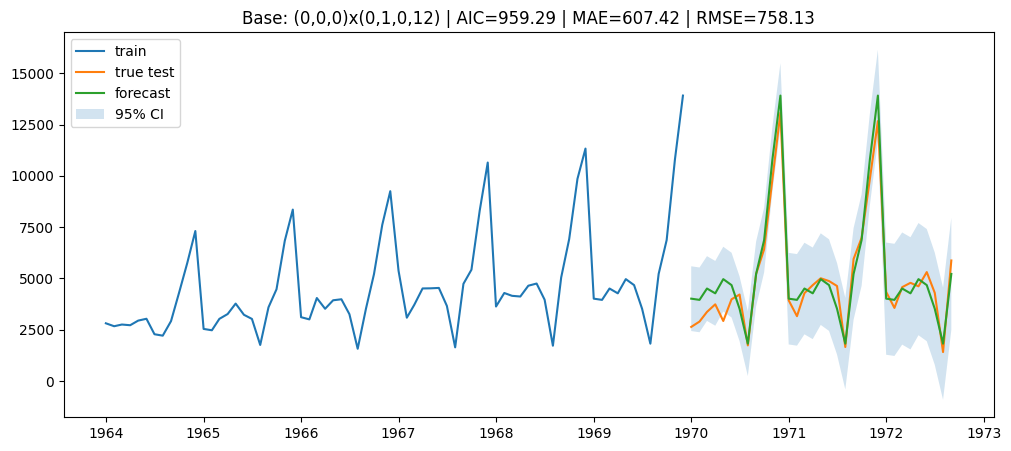

In [128]:
# SARIMA (0,0,0x(0,1,0,12))
res0= fit_forecast_plot(
    y_train, y_test,
    order=(0,0,0),
    seasonal_order=(0,1,0,12),
    title="Base: (0,0,0)x(0,1,0,12)"
)


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


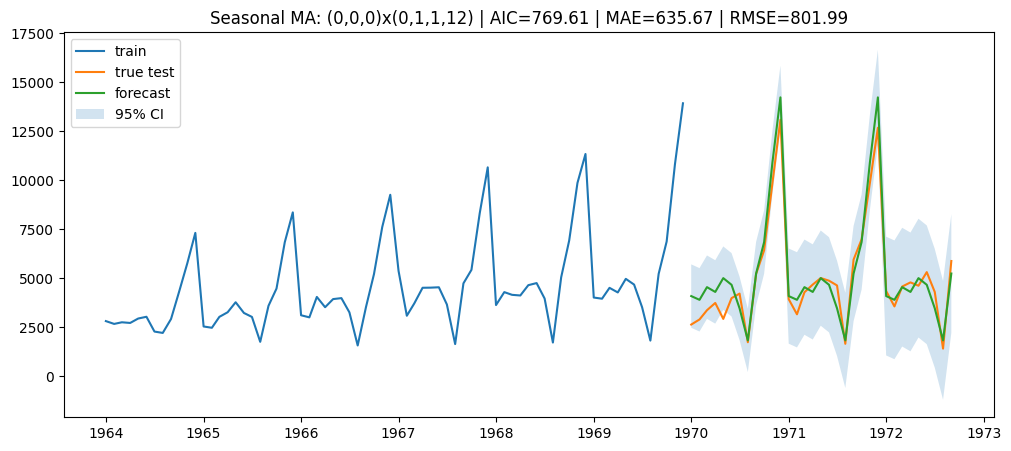

In [129]:
# SARIMA (0,0,0)x(0,1,1,12)
res1 = fit_forecast_plot(
    y_train, y_test,
    order=(0,0,0),
    seasonal_order=(0,1,1,12),
    title="Seasonal MA: (0,0,0)x(0,1,1,12)"
)


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


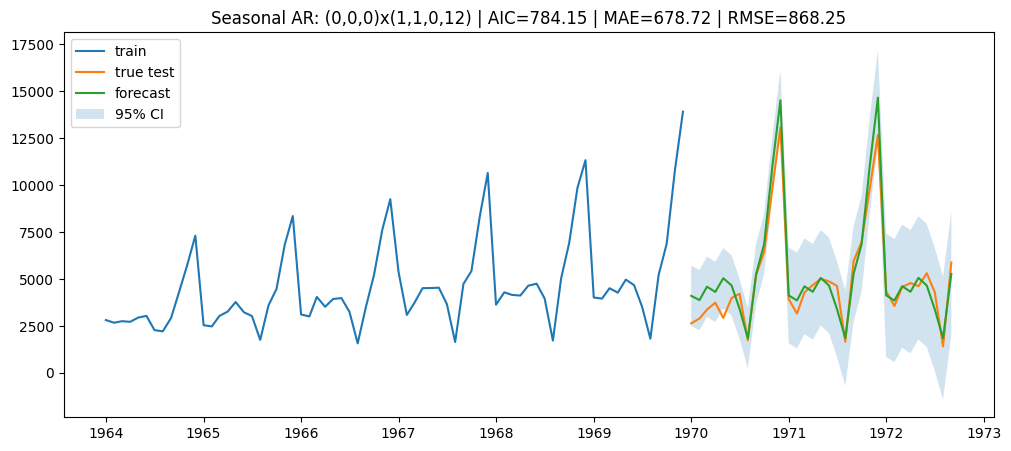

In [130]:
#SARIMA (0,0,0)x(1,1,0,12)
res2 = fit_forecast_plot(
    y_train, y_test,
    order=(0,0,0),
    seasonal_order=(1,1,0,12),
    title="Seasonal AR: (0,0,0)x(1,1,0,12)"
)


/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


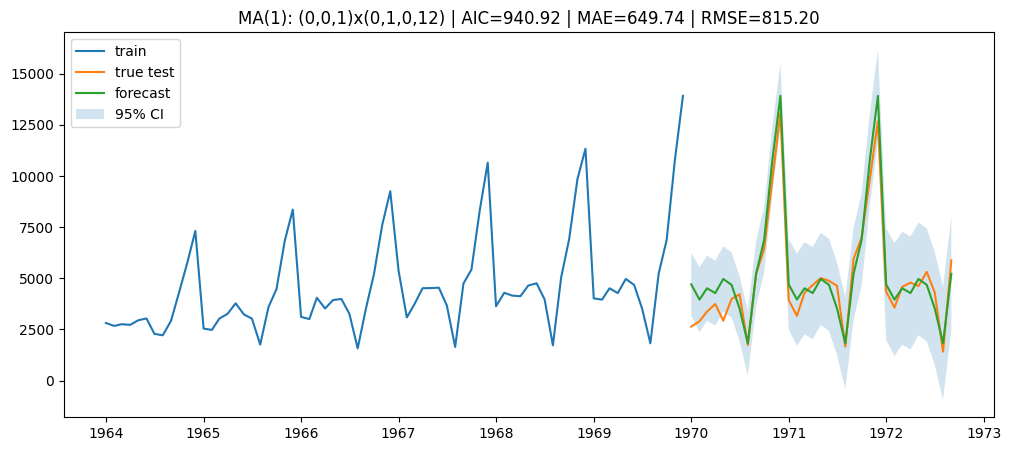

In [131]:
# SARIMA (0,0,1)x(0,1,0,12)
res3 = fit_forecast_plot(
    y_train, y_test,
    order=(0,0,1),
    seasonal_order=(0,1,0,12),
    title = "MA(1): (0,0,1)x(0,1,0,12)"
)

/Users/buseozgur/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


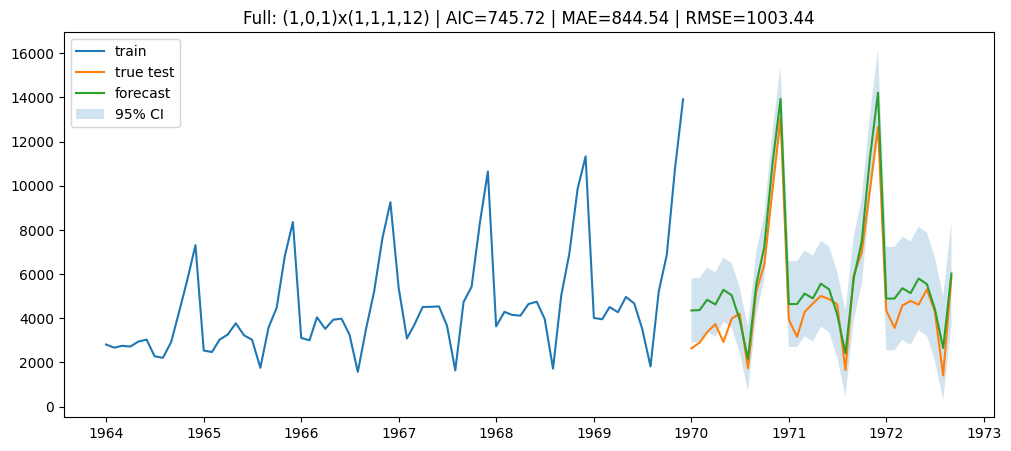

In [132]:
# SARIMA (1,0,1)x(1,1,1,12)
res4 = fit_forecast_plot(
    y_train, y_test,
    order=(1,0,1),
    seasonal_order=(1,1,1,12),
    title="Full: (1,0,1)x(1,1,1,12)"
)


# İSTEĞE BAĞLI - Makine Öğrenmesi Yaklaşımı

### Sadece 1 aylık tahmin ufku olan model

Şimdi Random Forest gibi doğrusal olmayan bir model uyduruyoruz. Fikir, son değerlerden bir değer tahmin etmektir.

👉 `df`'de `df['Sales']`'ın kaydırılmış versiyonu olan yeni sütunlar oluşturun. Bunu 1'den 12'ye kadar kaydırma ile yapın.

In [ ]:
# Create new columns
import pandas as pd

df_ml = df.copy()

# Lag columns 1 to 12
for lag in range(1, 13):
    df_ml[f"lag_{lag}"] = df_ml["Sales"].shift(lag)


df_ml.head(15)


,Sales,Sales_seasonal_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Month,,,,,,,,,,,,,,
1964-01-01,2815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-02-01,2672,NaN,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-03-01,2755,NaN,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-04-01,2721,NaN,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-05-01,2946,NaN,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-06-01,3036,NaN,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1964-07-01,2282,NaN,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN,NaN
1964-08-01,2212,NaN,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN,NaN
1964-09-01,2922,NaN,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0,NaN,NaN,NaN,NaN


In [ ]:
# Drop the N/A values
df_ml = df_ml.dropna()
df_ml.head(15)

,Sales,Sales_seasonal_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Month,,,,,,,,,,,,,,
1965-01-01,2541,-274.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0,2815.0
1965-02-01,2475,-197.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0,2672.0
1965-03-01,3031,276.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0,2755.0
1965-04-01,3266,545.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0,2721.0
1965-05-01,3776,830.0,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0,2946.0
1965-06-01,3230,194.0,3776.0,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0,3036.0
1965-07-01,3028,746.0,3230.0,3776.0,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0,2282.0
1965-08-01,1759,-453.0,3028.0,3230.0,3776.0,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0,2212.0
1965-09-01,3595,673.0,1759.0,3028.0,3230.0,3776.0,3266.0,3031.0,2475.0,2541.0,7312.0,5764.0,4301.0,2922.0


👉 Kaydırılmış özelliklerinize dayalı olarak Satışları tahmin etmek için bir `random forest` algoritması oluşturun (eğitmeyin)

In [ ]:
# Determine the features and target
X = df_ml[[f"lag_{lag}" for lag in range(1, 13)]]
y = df_ml["Sales"]

# Split the train and test sets
train_size = int(len(df_ml) * 0.8) #Cannot use the train_test_split because it is time series and randomly split can cause dangerous things!!!

X_train = X.iloc[:train_size]
X_test  = X.iloc[train_size:]

y_train = y.iloc[:train_size]
y_test  = y.iloc[train_size:]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42
)


👉 Test etmek için aşağıdaki fonksiyonu kullanabilirsiniz. Gerçek y değerlerini (`data` NumPy array olmalı), test örneklerinin indekslerini (`test_indexes`), tahmin ediciyi (`predictor`: random forest algoritmanız) ve kaydırılmış sütunları (`full_X` NumPy array olmalı) alır.

In [150]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score

def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0

    for _index in test_indexes:
        train_data = y_true[:_index]
        current_ground_truth = y_true[_index]
        current_ground_truth_features = full_X[_index,:]
        train_features = full_X[:_index]

        # train the model on all data points until (t-1) to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)

        i += 1

    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))

    return ground_truth, predictions, mape

In [155]:
# Arrange the model
import numpy as np

full_X = df_ml[[f"lag_{lag}" for lag in range(1, 13)]].to_numpy()
y_true = df_ml["Sales"].to_numpy()

test_mask = df_ml.index >= "1970-01-01"   # index datetime olmalı
test_indexes = np.where(test_mask)[0]

gt, preds, mape = evaluate_performance_month_prediction(
    y_true=y_true,
    test_indexes=test_indexes,
    predictor=rf,
    full_X=full_X
)

print("MAPE:", mape)

MAPE: 0.15838856401518198


Modelimizi iyileştirmek için özellik mühendisliği yapabiliriz. Random forest'ı eğitmek için kullanılan verilere hareketli ortalamalar ekleyeceksiniz.

`df`'de 3 yeni sütun oluşturmayı deneyin: biri 12 pencereli `df[Sales]`'ın hareketli ortalaması, biri 3 pencereli ve biri 2 pencereli. Bu, trendi izole etme ve algoritmanın öğrenmesine izin verme etkisine sahip olacaktır. Bu verileri çizin.


In [164]:
# Create moving average columns at df (2-window, 3-window, 12-window)
df_fe = df_ml.copy()
df_fe["ma_2"]  = df_fe["Sales"].rolling(window=2).mean()
df_fe["ma_3"]  = df_fe["Sales"].rolling(window=3).mean()
df_fe["ma_12"] = df_ml["Sales"].rolling(window=12).mean()

İstatistiksel olarak bir AR sürecini optimize eden üstel hareketli ortalama kullanarak daha güçlü bir yumuşatma tahmincisi de ekleyebilirsiniz (ipucu: 2, 3 ve 12 `halflife` ile `.ewm` metodu). Bu verileri çizin.

In [165]:
# Create Exponential Weighted Mean columns at df (2-halflife, 3-halflife, 12-halflife)
df_fe["ewm_2"]  = df_fe["Sales"].ewm(halflife=2).mean()
df_fe["ewm_3"]  = df_fe["Sales"].ewm(halflife=3).mean()
df_fe["ewm_12"] = df_fe["Sales"].ewm(halflife=12).mean()

df_fe = df_fe.dropna().copy()
df_fe.head(10)

,Sales,Sales_seasonal_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,ma_2,ma_3,ma_12,ewm_2,ewm_3,ewm_12
Month,,,,,,,,,,,,,,,,,,,,
1965-12-01,8357,1045.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3266.0,3031.0,2475.0,2541.0,7312.0,7597.5,6556.333333,3864.166667,5618.885775,5049.709582,4140.234108
1966-01-01,3113,572.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3266.0,3031.0,2475.0,2541.0,5735.0,6102.666667,3911.833333,4876.729074,4629.313107,4031.053503
1966-02-01,3006,531.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3266.0,3031.0,2475.0,3059.5,4825.333333,3956.083333,4324.490853,4280.698632,3927.308546
1966-03-01,4047,1016.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3266.0,3031.0,3526.5,3388.666667,4040.750000,4242.764183,4230.931505,3938.899858
1966-04-01,3523,257.0,4047.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3266.0,3785.0,3525.333333,4062.166667,4031.123413,4081.171079,3900.198580
1966-05-01,3937,161.0,3523.0,4047.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3776.0,3730.0,3835.666667,4075.583333,4003.478946,4050.831386,3903.501152
1966-06-01,3986,756.0,3937.0,3523.0,4047.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3230.0,3961.5,3815.333333,4138.583333,3998.349463,4037.244408,3910.663854
1966-07-01,3260,232.0,3986.0,3937.0,3523.0,4047.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,3028.0,3623.0,3727.666667,4157.916667,3781.792833,3874.885794,3855.854455
1966-08-01,1573,-186.0,3260.0,3986.0,3937.0,3523.0,4047.0,3006.0,3113.0,8357.0,6838.0,4474.0,3595.0,1759.0,2416.5,2939.666667,4142.416667,3134.219995,3395.287213,3668.813457


In [178]:
lag_cols = [f"lag_{i}" for i in range(1, 13)]

feature_cols = (
    lag_cols
    + ["ma_2", "ma_3", "ma_12"]
    + ["ewm_2", "ewm_3", "ewm_12"]
)


y = df_fe["Sales"].values
full_X = df_fe[feature_cols].values

n_obs = len(y)

test_size = 12
test_indexes = list(range(n_obs - test_size, n_obs))

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

gt, preds, mape = evaluate_performance_month_prediction(
    y_true=y,
    test_indexes=test_indexes,
    predictor=rf,
    full_X=full_X
)

print("MAPE:", mape)

MAPE: 0.13310585976259778


Daha iyi bir MAPE görmelisiniz!

Her özelliğin önemine bakmayı deneyin. Ne buluyorsunuz?


In [175]:
# Examine the importances of the features

import pandas as pd

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df


,feature,importance
11,lag_12,0.807479
12,ma_2,0.047617
10,lag_11,0.031388
15,ewm_2,0.018822
1,lag_2,0.012895
13,ma_3,0.012558
16,ewm_3,0.012160
9,lag_10,0.011843
17,ewm_12,0.007090
5,lag_6,0.007037


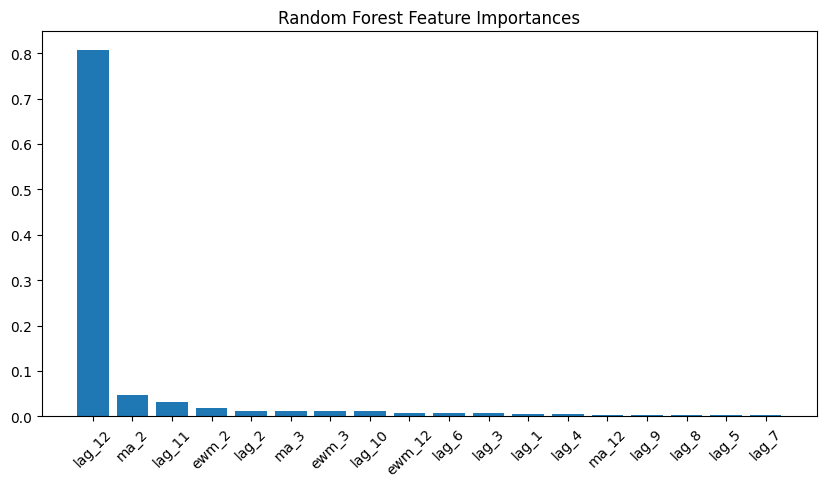

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(feature_importance_df["feature"], feature_importance_df["importance"])
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importances")
plt.show()


In [ ]:
# To see what is the difference of MAPE if we execute lag_12(the most importance feature) to examine seasonallity
lag_cols = [f"lag_{i}" for i in range(1, 13)]

feature_cols = (
    lag_cols
    + ["ma_2", "ma_3", "ma_12"]
    + ["ewm_2", "ewm_3", "ewm_12"]
)
feature_cols_no_lag12 = [c for c in feature_cols if c != "lag_12"]

y = df_fe["Sales"].values
full_X = df_fe[feature_cols_no_lag12].values

n_obs = len(y)

test_size = 12
test_indexes = list(range(n_obs - test_size, n_obs))

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

gt, preds, mape = evaluate_performance_month_prediction(
    y_true=y,
    test_indexes=test_indexes,
    predictor=rf,
    full_X=full_X
)

print("MAPE:", mape) # MAPE difference is +%4

MAPE: 0.17342569964913168


### Örneklem-Dışı Tahmin Modelleri

Şimdi "örneklem-dışı" tahminde SARIMA'yı geçmeyi deneyelim.

👉 _Her tahmin ufku için bir model eğitin_ (`1`-aylık ufuktan `len(y_test)` aya kadar)
👉 MAPE'yi değerlendirin ve SARIMA ile karşılaştırın

In [ ]:
# Out of Sample SARIMA
horizons = range(1, len(y_test) + 1)

import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_out_of_sample_mape(y_train, y_test, order, seasonal_order, max_horizon):
    mape_per_horizon = []

    for h in range(1, max_horizon + 1):
        preds = []
        trues = []

        for i in range(len(y_test) - h + 1):
            train_series = np.concatenate([y_train, y_test[:i]])

            model = SARIMAX(
                train_series,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)

            forecast = res.forecast(steps=h)
            preds.append(forecast[-1])
            trues.append(y_test[i + h - 1])

        mape = np.mean(np.abs((np.array(trues) - np.array(preds)) / np.array(trues)))
        mape_per_horizon.append(mape)

    return mape_per_horizon
sarima_mape = sarima_out_of_sample_mape(
    y_train=y_train.values,
    y_test=y_test.values,
    order=(1,0,1),
    seasonal_order=(1,1,1,12),
    max_horizon=len(y_test)
)


In [192]:
# Out of Sample RF
rf_mape = []

for h in range(1, len(test_indexes) + 1):
    current_test_indexes = test_indexes[:h]

    gt, preds, mape = evaluate_performance_month_prediction(
        y_true=y,
        test_indexes=current_test_indexes,
        predictor=rf,
        full_X=full_X
    )

    rf_mape.append(mape)


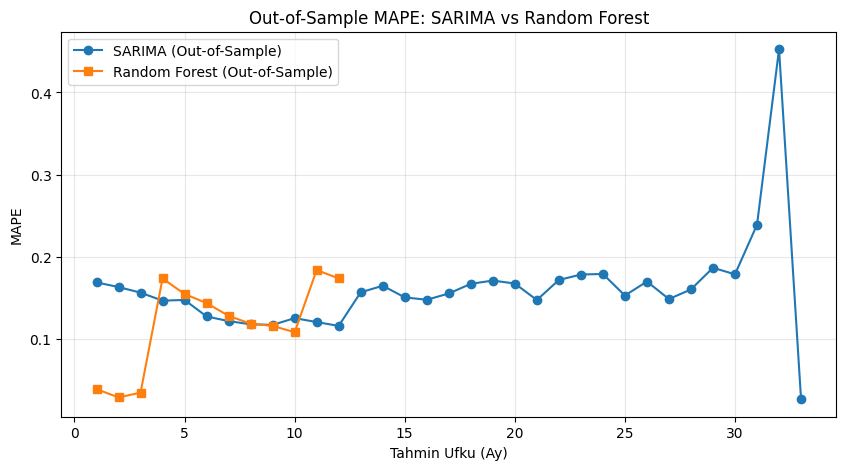

In [ ]:
# SARIMA horizon
sarima_horizons = range(1, len(sarima_mape) + 1)

# RF horizon
rf_horizons = range(1, len(rf_mape) + 1)

plt.figure(figsize=(10, 5))

plt.plot(
    sarima_horizons,
    sarima_mape,
    marker="o",
    label="SARIMA (Out-of-Sample)"
)

plt.plot(
    rf_horizons,
    rf_mape,
    marker="s",
    label="Random Forest (Out-of-Sample)"
)

plt.xlabel("Tahmin Ufku (Ay)")
plt.ylabel("MAPE")
plt.title("Out-of-Sample MAPE: SARIMA vs Random Forest")
plt.legend()
plt.grid(alpha=0.3)

plt.show()
